In [13]:
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import torch
from datasets import Dataset
from itertools import chain
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    LEDForConditionalGeneration,
    LEDTokenizer,
    Seq2SeqTrainingArguments,
    Trainer
)
from datasets import load_dataset, Dataset,DatasetDict


In [7]:
!nvidia-smi


Sun Oct 20 19:10:43 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A40                     Off |   00000000:01:00.0 Off |                    0 |
|  0%   68C    P0            227W /  300W |   26764MiB /  46068MiB |     91%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
import torch

# Set the device to CUDA:3
torch.cuda.set_device(3)

# Clear the cache
torch.cuda.empty_cache()


In [5]:


# Check if CUDA is available
if torch.cuda.is_available():
    # Get the number of GPUs available
    num_gpus = torch.cuda.device_count()
    
    if num_gpus >= 3:  # Check if there are at least 3 GPUs
        # Set the device to GPU 2
        device = torch.device("cuda:3")
        print(f"Set device to: {device}")
        print(f"GPU Name: {torch.cuda.get_device_name(3)}")
        
        # Set GPU 2 as the default device
        torch.cuda.set_device(3)
        
        # Verify the current device
        current_device = torch.cuda.current_device()
        print(f"Current process is using GPU ID: {current_device}, GPU Name: {torch.cuda.get_device_name(current_device)}")
        
        # Test tensor creation
        test_tensor = torch.randn(10, 10, device=device)
        print(f"Test tensor is on device: {test_tensor.device}")
        
        # Example model placement
        class SimpleModel(torch.nn.Module):
            def __init__(self):
                super().__init__()
                self.linear = torch.nn.Linear(10, 10)
            
            def forward(self, x):
                return self.linear(x)
        
        model = SimpleModel()
        model.to(device)
        print(f"Model is on device: {next(model.parameters()).device}")
    
    else:
        print("Device 2 is not available. Using Device 0.")
        device = torch.device("cuda:0")
else:
    print("CUDA is not available. Using CPU.")
    device = torch.device("cpu")

print(f"Final check: Current process is using GPU ID: {torch.cuda.current_device()}, GPU Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")


Set device to: cuda:3
GPU Name: NVIDIA A40
Current process is using GPU ID: 3, GPU Name: NVIDIA A40
Test tensor is on device: cuda:3
Model is on device: cuda:3
Final check: Current process is using GPU ID: 3, GPU Name: NVIDIA A40


In [4]:
if torch.cuda.is_available():
    print("CUDA is available")
    print("Number of GPUs:", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
        print(torch.cuda.current_device())
else:
    print("CUDA is not available")


CUDA is available
Number of GPUs: 4
Device 0: NVIDIA A40
0
Device 1: NVIDIA A40
0
Device 2: NVIDIA A40
0
Device 3: NVIDIA A40
0


In [7]:
device = torch.device("cpu")
print(f"Final check: Current process is using GPU ID: {torch.cuda.current_device()}, GPU Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")


Final check: Current process is using GPU ID: 2, GPU Name: NVIDIA A40


In [7]:
import torch

device = torch.device("cpu")
print(f"Using device: {device}")


Using device: cpu


In [21]:

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the current device
    current_device = torch.cuda.current_device()
    print(f"Current process is using GPU ID: {current_device}, GPU Name: {torch.cuda.get_device_name(current_device)}")
else:
    print("CUDA is not available.")

Current process is using GPU ID: 2, GPU Name: NVIDIA A40


In [14]:

file_path = './case_with_all_sources_with_companion_cases_tag.jsonl'


def read_jsonl_file(file_path):
    data = []
    # Read the JSONL file line by line
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return data



In [15]:
data = read_jsonl_file(file_path)

In [24]:
# Example usage to find all cases with the subkey 'Case' under 'justia_sections' containing the phrases
phrases_end = [
    'it is so ordered.',
    'is so ordered.',
    'It is so. ordered.',
    ' so ordered.',
    'The judgment of the Court of Appeals is Affirmed.',
    'Affirmed. Justice',
    'isAffirmed.JUSTICE',
    'Affirmed.JUSTICE',
    'The judgment of the Court of Appeals isAffirmed.',
    'judgment of the Court of Appeals is thereforeAffirmed.JUSTICE',
    'thereforeAffirmed.JUSTICE',
    'thereforeAffirmed',
    'thereforeReversed.JUSTICE',
    'thereforeReversed.',
    'Reversed.JUSTICE',
    'judgment of the Court of Appeals isReversed.JUSTICE',
    'Appeals isReversed.',
    'isReversed.JUSTICE',
    'isReversed.',
    'isReversed.3',
    'therefore Reversed.',
    'is accordinglyReversed.',
    'Court is Affirmed in part and reversed in part.JUSTICE',
    'accordinglyAffirmed.',
    'Reversed. Page',
    'Reversed. *',
    '. Reversed.',
    '. Affirmed.',
    'relief.Affirmed.',
    '.Affirmed.,',
    'Affirmed. *',
    '* Affirmed.',
    'Reversed and remanded.',
    'isAffirmed.',
    'Reversed. Justice',
    'Affirmed. [Footnote 1]',
    'Affirmed.[Footnote 1]',
    'Reversed. [Footnote 1]',
    'Reversed.[Footnote 1]',
    'Reversed[Footnote 1]',
    'Affirmed[Footnote 1]',
    'Affirmed in part and reversed in part.JUSTICE',
    'Affirmed in part and reversed in part. JUSTICE',
    'The judgment of the District Court isReversed.',
    'The judgment of the District Court is Reversed.',
    'the writ of certiorari isDismissed.',
    '4]Reversed.',
    '.[Footnote 1]',
    'the judgment isReversed.',
    'the judgment is Reversed.',
    'The judgments areReversed.',
    'The judgments are Reversed.',
    'so ordered',
    'is affirmed',
    'supra.Affirmed.JUSTICE',
    'is accordinglyReversed.6',
    '[Footnote 1]'
]


In [ ]:
# OLD CODE
def FindCasesWithPhrase(data, subkey, phrases_end):
    cases_with_phrases = []
    cases_without_phrases = []
    cases_with_per_curiam = []
    cases_without_phrases_end = []

    # Compile the regular expressions for better performance
    # compiled_phrases_end = [re.compile(phrase, re.IGNORECASE) for phrase in phrases_end]
    compiled_phrases_end = [re.compile(re.escape(phrase), re.IGNORECASE) for phrase in phrases_end]

    per_curiam_pattern = re.compile(r'Per Curiam', re.IGNORECASE)

    for item in data:
        if 'justia_sections' in item and subkey in item['justia_sections']:
            case_text = item['justia_sections'][subkey]
            # Remove newlines from the case text
            case_text = case_text.replace('\n', ' ')

            # Remove the text from justia_sections['Syllabus'] if it exists
            if 'Syllabus' in item['justia_sections']:
                syllabus_text = item['justia_sections']['Syllabus'].replace('\n', ' ')
                case_text = case_text.replace(syllabus_text, '')

            # Find the first match for phrases_end
            match_end = next((phrase.search(case_text) for phrase in compiled_phrases_end if phrase.search(case_text)), None)
            if match_end:
                # Add the end phrase to the item
                item['opinion_end_phrase'] = match_end.group()
                cases_with_phrases.append(item)
            else:
                if per_curiam_pattern.search(case_text):
                    cases_with_per_curiam.append(item)
                else:
                    cases_without_phrases.append(item)
                    cases_without_phrases_end.append(item)

    return cases_with_phrases, cases_without_phrases, cases_with_per_curiam, cases_without_phrases_end

def ExtractOpinionOfTheCourt(cases):
    for item in cases:
        case_text = item['justia_sections']['Case']
        # Remove newlines from the case text
        case_text = case_text.replace('\n', ' ')

        # Remove the text from justia_sections['Syllabus'] if it exists
        if 'Syllabus' in item['justia_sections']:
            syllabus_text = item['justia_sections']['Syllabus'].replace('\n', ' ')
            case_text = case_text.replace(syllabus_text, '')

        # Use the pre-stored end phrase to extract the opinion
        if 'opinion_end_phrase' in item:
            end_phrase = item['opinion_end_phrase']
            end = case_text.find(end_phrase)
            if end != -1:
                opinion_text = case_text[:end].strip()
                item['opinionOfTheCourt'] = opinion_text

    return cases


# Assuming 'data' is defined elsewhere in your code
cases_with_phrases, cases_without_phrases, cases_with_per_curiam, cases_without_phrases_end = FindCasesWithPhrase(data, 'Case', phrases_end)
# Extract opinions of the court
cases_with_opinions = ExtractOpinionOfTheCourt(cases_with_phrases)


In [15]:
#FAST FindCasesWithPhrase 

data = read_jsonl_file(file_path)
# Compile the regular expressions once
syllabus_pattern = re.compile(r'syllabus', re.IGNORECASE)
per_curiam_pattern = re.compile(r'Per Curiam', re.IGNORECASE)

# Function to remove everything before and including the word "syllabus"
# def remove_before_syllabus(text):
#     match = syllabus_pattern.search(text)
#     if match:
#         return text[match.end():]
#     return text

def remove_before_syllabus(text):
    match = re.search(r'syllabus', text, re.IGNORECASE)
    if match:
        return text[match.end():]
    return text

# Function to remove spaces from text
def remove_spaces(text):
    return re.sub(r'\s+', '', text)

# Function to remove syllabus text from case text
def remove_syllabus_from_case(case_text, syllabus_text):
    # Remove everything before and including "syllabus"
    syllabus_text = remove_before_syllabus(syllabus_text)
    case_text = remove_before_syllabus(case_text)

    # Remove all spaces from both texts
    syllabus_text_no_spaces = remove_spaces(syllabus_text)
    case_text_no_spaces = remove_spaces(case_text)

    # Remove the part of case_text that is equal to syllabus_text, case-insensitively
    pattern = re.compile(re.escape(syllabus_text_no_spaces), re.IGNORECASE)
    case_text_no_spaces = pattern.sub('', case_text_no_spaces)

    # Restore spaces in case_text
    restored_text = []
    mod_index = 0
    for char in case_text:
        if mod_index < len(case_text_no_spaces) and char.lower() == case_text_no_spaces[mod_index].lower():
            restored_text.append(char)
            mod_index += 1
        elif char.isspace():
            restored_text.append(char)

    # Remove leading and trailing spaces
    return ''.join(restored_text).strip()

def remove_double_spaces(text):
    # Use regular expression to replace consecutive spaces with a single space
    return ' '.join(text.split())

# Build Dataset to get majority opinion
def FindCasesWithPhrase(data, subkey, phrases_end):
    cases_with_phrases = []
    cases_without_phrases = []
    cases_with_per_curiam = []
    cases_without_phrases_end = []

    # Compile the regular expressions for better performance
    compiled_phrases_end = [re.compile(re.escape(phrase), re.IGNORECASE) for phrase in phrases_end]

    for item in data:
        if 'justia_sections' in item and subkey in item['justia_sections']:
            case_text = item['justia_sections'][subkey].replace('\n', ' ')
            

            # Remove the text from justia_sections['Syllabus'] if it exists
            if 'Syllabus' in item['justia_sections']:
                syllabus_text = item['justia_sections']['Syllabus'].replace('\n', ' ')
                case_text = remove_syllabus_from_case(case_text, syllabus_text)
            # Find the first match for phrases_end
            match_end = next((phrase.search(case_text) for phrase in compiled_phrases_end if phrase.search(case_text)), None)
            if match_end:
                # Add the end phrase to the item
                item['opinion_end_phrase'] = match_end.group()
                cases_with_phrases.append(item)

                # Extract the opinion of the court
                end = case_text.find(item['opinion_end_phrase'])
                if end != -1:
                    opinion_text = case_text[:end + len(item['opinion_end_phrase'])].strip()
                    item['opinionOfTheCourt'] = remove_double_spaces(opinion_text)
            else:
                if per_curiam_pattern.search(case_text):
                    cases_with_per_curiam.append(item)
                else:
                    cases_without_phrases.append(item)
                    cases_without_phrases_end.append(item)

    return cases_with_phrases, cases_without_phrases, cases_with_per_curiam, cases_without_phrases_end

# Example usage
subkey = 'Case'

cases_with_phrases_FAST_1, cases_without_phrases, cases_with_per_curiam, cases_without_phrases_end = FindCasesWithPhrase(data, subkey, phrases_end)

count_cases_with_phrases = len(cases_with_phrases_FAST_1)
count_cases_without_phrases = len(cases_without_phrases)
count_cases_with_per_curiam = len(cases_with_per_curiam)
count_cases_without_phrases_end = len(cases_without_phrases_end)

print(f"Number of cases with 'Case' subkey under 'justia_sections' containing end phrases: {count_cases_with_phrases}")
print(f"Number of cases with 'Case' subkey under 'justia_sections' not containing end phrases: {count_cases_without_phrases}")
print(f"Number of cases with 'Case' subkey under 'justia_sections' containing 'Per Curiam': {count_cases_with_per_curiam}")
print(f"Number of cases with 'Case' subkey under 'justia_sections' not containing phrases_end: {count_cases_without_phrases_end}")

cases_FAST_1  = FilterCases(cases_with_phrases_FAST_1)
df_FAST_1 = convert_cases_to_dataframe(cases_FAST_1 )
convert_and_upload_data(cases_FAST_1,'FILTERED_FAST_1')
# upload_dataframe_to_huggingface(df_FAST_1, 'FILTERED_FAST_1')


Number of cases with 'Case' subkey under 'justia_sections' containing end phrases: 5289
Number of cases with 'Case' subkey under 'justia_sections' not containing end phrases: 196
Number of cases with 'Case' subkey under 'justia_sections' containing 'Per Curiam': 22
Number of cases with 'Case' subkey under 'justia_sections' not containing phrases_end: 196


Uploading the dataset shards: 100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


In [16]:
len(cases_FAST_1)

5260

In [17]:
#SLOW FindCasesWithPhrase 
data = read_jsonl_file(file_path)

# Function to remove everything before and including the word "syllabus"
def remove_before_syllabus(text):
    match = re.search(r'syllabus', text, re.IGNORECASE)
    if match:
        return text[match.end():]
    return text

# Function to remove spaces from text
def remove_spaces(text):
    return re.sub(r'\s+', '', text)

def remove_double_spaces(text):
    # Use regular expression to replace consecutive spaces with a single space
    return ' '.join(text.split())

# Function to restore spaces in the original case_text
def restore_spaces(original, modified, removed_indices):
    restored = []
    mod_index = 0
    for i, char in enumerate(original):
        if i in removed_indices:
            continue
        if mod_index < len(modified) and char.lower() == modified[mod_index].lower():
            restored.append(char)
            mod_index += 1
        elif char.isspace():
            restored.append(char)
    return ''.join(restored)

# Function to remove syllabus text from case text
def remove_syllabus_from_case(case_text, syllabus_text):
    # Remove everything before and including "syllabus"
    syllabus_text = remove_before_syllabus(syllabus_text)
    case_text = remove_before_syllabus(case_text)

    # Remove all spaces from both texts
    syllabus_text_no_spaces = remove_spaces(syllabus_text)
    case_text_no_spaces = remove_spaces(case_text)

    # Remove the part of case_text that is equal to syllabus_text, case-insensitively
    pattern = re.compile(re.escape(syllabus_text_no_spaces), re.IGNORECASE)
    case_text_no_spaces = pattern.sub('', case_text_no_spaces)

    # Track indices of removed characters
    removed_indices = []
    mod_index = 0
    for i, char in enumerate(case_text):
        if mod_index < len(syllabus_text_no_spaces) and char.lower() == syllabus_text_no_spaces[mod_index].lower():
            removed_indices.append(i)
            mod_index += 1

    # Restore spaces in case_text
    case_text_with_spaces = restore_spaces(case_text, case_text_no_spaces, removed_indices)

    # Remove leading and trailing spaces
    return case_text_with_spaces.strip()

# Build Dataset to get majority opinion
def FindCasesWithPhrase(data, subkey, phrases_end):
    cases_with_phrases = []
    cases_without_phrases = []
    cases_with_per_curiam = []
    cases_without_phrases_end = []

    # Compile the regular expressions for better performance
    compiled_phrases_end = [re.compile(re.escape(phrase), re.IGNORECASE) for phrase in phrases_end]
    per_curiam_pattern = re.compile(r'Per Curiam', re.IGNORECASE)

    for item in data:
        if 'justia_sections' in item and subkey in item['justia_sections']:
            case_text = item['justia_sections'][subkey]
            # Remove newlines from the case text
            case_text = case_text.replace('\n', ' ')

            # Remove the text from justia_sections['Syllabus'] if it exists
            if 'Syllabus' in item['justia_sections']:
                syllabus_text = item['justia_sections']['Syllabus'].replace('\n', ' ')
                case_text = remove_syllabus_from_case(case_text, syllabus_text)

            # Find the first match for phrases_end
            match_end = next((phrase.search(case_text) for phrase in compiled_phrases_end if phrase.search(case_text)), None)
            if match_end:
                # Add the end phrase to the item
                item['opinion_end_phrase'] = match_end.group()
                cases_with_phrases.append(item)

                # Extract the opinion of the court
                end = case_text.find(item['opinion_end_phrase'])
                if end != -1:
                    opinion_text = case_text[:end + len(item['opinion_end_phrase'])].strip()
                    item['opinionOfTheCourt'] = remove_double_spaces(opinion_text)
            else:
                if per_curiam_pattern.search(case_text):
                    cases_with_per_curiam.append(item)
                else:
                    cases_without_phrases.append(item)
                    cases_without_phrases_end.append(item)

    return cases_with_phrases, cases_without_phrases, cases_with_per_curiam, cases_without_phrases_end


subkey = 'Case'

cases_with_phrases_SLOW, cases_without_phrases, cases_with_per_curiam, cases_without_phrases_end = FindCasesWithPhrase(data, subkey, phrases_end)

count_cases_with_phrases = len(cases_with_phrases_SLOW)
count_cases_without_phrases = len(cases_without_phrases)
count_cases_with_per_curiam = len(cases_with_per_curiam)
count_cases_without_phrases_end = len(cases_without_phrases_end)

print(f"Number of cases with 'Case' subkey under 'justia_sections' containing end phrases: {count_cases_with_phrases}")
print(f"Number of cases with 'Case' subkey under 'justia_sections' not containing end phrases: {count_cases_without_phrases}")
print(f"Number of cases with 'Case' subkey under 'justia_sections' containing 'Per Curiam': {count_cases_with_per_curiam}")
print(f"Number of cases with 'Case' subkey under 'justia_sections' not containing phrases_end: {count_cases_without_phrases_end}")

cases_slow = FilterCases(cases_with_phrases_SLOW)

df_slow = convert_cases_to_dataframe(cases_slow)

convert_and_upload_data(cases_slow,'FILTERED_SLOW')

Number of cases with 'Case' subkey under 'justia_sections' containing end phrases: 4288
Number of cases with 'Case' subkey under 'justia_sections' not containing end phrases: 1183
Number of cases with 'Case' subkey under 'justia_sections' containing 'Per Curiam': 36
Number of cases with 'Case' subkey under 'justia_sections' not containing phrases_end: 1183


Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.87s/it]


In [1]:
len(cases_slow)

NameError: name 'cases_slow' is not defined

In [25]:
from datasets import load_dataset

def load_datasets(dataset1_name, dataset2_name):

    dataset1 = load_dataset(dataset1_name)
    dataset2 = load_dataset(dataset2_name)
    return dataset1, dataset2

def get_unique_urls(dataset1, dataset2):
    """
    Get URLs that are in dataset1 but not in dataset2.
    
    Parameters:
    - dataset1: The first dataset.
    - dataset2: The second dataset.
    
    Returns:
    A list of URLs that are in dataset1 but not in dataset2.
    """
    urls1 = set(dataset1['train']['url'])
    urls2 = set(dataset2['train']['url'])
    
    unique_urls = urls1 - urls2
    return list(unique_urls)

# Example usage
dataset1_name = 'ahmed275/FILTERED_FAST_1'
dataset2_name = 'ahmed275/FILTERED_SLOW'

# Load the datasets
dataset1, dataset2 = load_datasets(dataset1_name, dataset2_name)

# Get the unique URLs
unique_urls = get_unique_urls(dataset1, dataset2)

# Print the unique URLs
print("URLs in dataset1 but not in dataset2:")
for url in unique_urls:
    print(url)


Generating train split: 100%|██████████| 4270/4270 [00:00<00:00, 11262.26 examples/s]

URLs in dataset1 but not in dataset2:
https://www.oyez.org/cases/1998/98-131
https://www.oyez.org/cases/1991/90-8466
https://www.oyez.org/cases/1996/96-542
https://www.oyez.org/cases/2000/99-9073
https://www.oyez.org/cases/1960/236
https://www.oyez.org/cases/1997/97-463
https://www.oyez.org/cases/1996/95-1232
https://www.oyez.org/cases/1996/95-1263
https://www.oyez.org/cases/2000/99-1977
https://www.oyez.org/cases/2002/02-94
https://www.oyez.org/cases/1995/94-947
https://www.oyez.org/cases/1993/93-5131
https://www.oyez.org/cases/1993/92-896
https://www.oyez.org/cases/1997/97-372
https://www.oyez.org/cases/1998/97-53
https://www.oyez.org/cases/2001/01-679
https://www.oyez.org/cases/1998/97-1754
https://www.oyez.org/cases/1995/94-9088
https://www.oyez.org/cases/1991/90-1604
https://www.oyez.org/cases/1998/98-262
https://www.oyez.org/cases/2002/02-371
https://www.oyez.org/cases/1997/97-371
https://www.oyez.org/cases/1993/91-1950
https://www.oyez.org/cases/2000/00-276
https://www.oyez.org/

In [26]:
len(unique_urls)

990

In [5]:
# get opinions from cases that does NOT have subkey Case and have the opinion right away

cases_with_opinion = []

# Iterate over each item in the data
for item in data:
    if 'justia_sections' in item:
        justia_sections = item['justia_sections']
        
        # Check for any subkey containing 'Opinion' and the presence of 'Syllabus'
        opinion_keys = [key for key in justia_sections if 'Opinion' in key]
        if opinion_keys and 'Syllabus' in justia_sections:
            # Combine all opinion texts into one
            combined_opinion_text = ' '.join(justia_sections[key].replace('\n', ' ') for key in opinion_keys)
            
            # Add the combined opinion text to the item
            item['opinionOfTheCourt'] = combined_opinion_text
            
            # Add the modified item to the list
            cases_with_opinion.append(item)


In [27]:
print(len(cases_with_opinion))

1097


In [9]:
cases_opinion  = FilterCases(cases_with_opinion)
df_opinion = convert_cases_to_dataframe(cases_opinion )
convert_and_upload_data(cases_FAST_1,'FILTERED_FAST_1')

In [11]:
print(cases_opinion[0]['opinionOfTheCourt'])

   OPINION OF THE COURT AETNA HEALTH INC. V. DAVILA 542 U. S. ____ (2004)  SUPREME COURT OF THE UNITED STATES NOS. 02-1845 AND 03-83   AETNA HEALTH INC., fka AETNA U. S. HEALTHCARE INC. and AETNA U. S. HEALTHCARE OF NORTH TEXAS INC., PETITIONER  02–1845   v.  JUAN DAVILA  CIGNA HEALTHCARE OF TEXAS, INC., dba CIGNA CORPORATION, PETITIONER  03–83   v.  RUBY R. CALAD et al. on writs of certiorari to the united states court of appeals for the fifth circuit [June 21, 2004]    Justice Thomas delivered the opinion of the Court.     In these consolidated cases, two individuals sued their respective health maintenance organizations (HMOs) for alleged failures to exercise ordinary care in the handling of coverage decisions, in violation of a duty imposed by the Texas Health Care Liability Act (THCLA), Tex. Civ. Prac. & Rem. Code Ann. §§88.001–88.003 (2004 Supp. Pamphlet).  We granted certiorari to decide whether the individuals’ causes of action are completely pre-empted by the “interlocking, in

In [25]:


# Initialize a counter
count_opinion_phrases = 0
cases_opinion_without_delivered = []
# Iterate over each case in cases_with_opinion
# for case in cases_opinion:
#     # Check if the phrase is in the opinionOfTheCourt text
#     if 'delivered the opinion of the Court' in case.get('opinionOfTheCourt', ''):
#         count_opinion_phrases += 1
#     else:   
#         cases_opinion_without_delivered.append(case)



phrases = ["delivered the opinion of the Court", "delivered an opinion"]

# Iterate over each case in cases_with_opinion
for case in cases_with_opinion:
    opinion_text = case.get('opinionOfTheCourt', '')
    # Check if any of the phrases are in the opinion text
    if any(phrase in opinion_text for phrase in phrases):
        count_opinion_phrases += 1



# Print the result
print(f"Number of cases with 'delivered the opinion of the Court': {count_opinion_phrases}")

Number of cases with 'delivered the opinion of the Court': 1096


In [26]:
import re



# Initialize a counter
count_multiple_occurrences = 0

# Define the phrases to search for
phrases = ["delivered the opinion of the Court", "delivered an opinion"]

# Iterate over each case in cases_with_opinion
for case in cases_with_opinion:
    opinion_text = case.get('opinionOfTheCourt', '')
    # Check if any of the phrases occur more than once
    for phrase in phrases:
        if len(re.findall(re.escape(phrase), opinion_text)) > 1:
            count_multiple_occurrences += 1
            break  # No need to check other phrases if one is found multiple times

# Print the result
print(f"Number of cases with phrases occurring more than once: {count_multiple_occurrences}")

Number of cases with phrases occurring more than once: 4


In [ ]:

# Define the phrases to search for
phrases = ["delivered the opinion of the Court", "delivered an opinion"]

# Iterate over each case in cases_with_opinion
for case in cases_with_opinion:
    opinion_text = case.get('opinionOfTheCourt', '')
    
    # Create a regex pattern to match any text up to and including the first occurrence of any phrase
    pattern = r'^.*?(' + '|'.join(re.escape(phrase) for phrase in phrases) + ')'
    
    # Remove text up to and including the first occurrence of the phrases
    case['opinionOfTheCourt'] = re.sub(pattern, '', opinion_text, flags=re.DOTALL).strip()

# Print the modified cases
for case in cases_with_opinion:
    print(case)

In [15]:

print(cases_opinion_without_delivered[0]['opinionOfTheCourt'])

   OPINION OF REHNQUIST, C.&NBSP;J. BEDROC LIMITED, LLC V. UNITED STATES 541 U. S. ____ (2004)  SUPREME COURT OF THE UNITED STATES NO. 02-1593  BEDROC LIMITED, LLC, and WESTERN ELITE, INC., PETITIONERS v. UNITED STATES et al. on writ of certiorari to the united states court of appeals for the ninth circuit [March 31, 2004]    Chief Justice Rehnquist announced the judgment of the Court and delivered an opinion, in which Justice O’Connor, Justice Scalia, and Justice Kennedy join.     The question here is whether sand and gravel are “valuable minerals” reserved to the United States in land grants issued under the Pittman Underground Water Act of 1919 (Pittman Act or Act), ch. 77, 41 Stat. 293.  We hold they are not.      Beginning with the Homestead Act of 1862, ch. 75, 12 Stat. 392, and stretching into the early 20th century, Congress enacted a series of land-grant statutes aimed at settling the American frontier.  One of these was the Pittman Act.  That Act sought to succeed where earli

In [ ]:
convert_and_upload_data(cases_FAST_1,'FILTERED_FAST_1')

In [8]:
def FilterCases(cases):
    filtered_cases = []
    for case in cases:
        if 'scdb_elements' in case:
            scdb_elements = case['scdb_elements']
            if 'issueArea' in scdb_elements and 'decisionDirection' in scdb_elements:
                if not (scdb_elements['issueArea'] is None or (isinstance(scdb_elements['issueArea'], float) and math.isnan(scdb_elements['issueArea']))):
                    if scdb_elements['decisionDirection'] != 3:
                        filtered_cases.append(case)
    return filtered_cases

# print(f"Sylllabus: { cases_with_phrases[110]['justia_sections']['Syllabus']}")
# print(f"Case: { cases_with_phrases[110]['justia_sections']['Case']}")
# print(f"Opiinion: { cases_with_phrases[110]['opinionOfTheCourt']}")

# Filter cases based on the criteria
# filtered_cases_with_opinions_fast = FilterCases(cases_with_phrases)

In [11]:
def convert_and_upload_data(cases,name):
    # Convert cases_with_opinions to a pandas DataFrame
    data_opinion = []
    for item in cases:
        data_opinion.append({
            'id': item['id'],
            'year': item['year'],
            'url': item['url'],
            'opinionOfTheCourt': item['opinionOfTheCourt'],
            'syllabus': item['justia_sections']['Syllabus'],
            'issueArea': item['scdb_elements']['issueArea'],
            'decisionDirection': item['scdb_elements']['decisionDirection']
        })
    
    df = pd.DataFrame(data_opinion)
    
    # Convert DataFrame to a Dataset object
    dataset = Dataset.from_pandas(df)
    
    # Push the dataset to the Hugging Face Hub
    dataset.push_to_hub(f"ahmed275/{name}", private=False)


In [29]:

def convert_cases_to_dataframe(cases):
    data_opinion = []
    for item in cases:
        data_opinion.append({
            'id': item['id'],
            'year': item['year'],
            'url': item['url'],
            'opinionOfTheCourt': item['opinionOfTheCourt'],
            'syllabus': item['justia_sections']['Syllabus'],
            'issueArea': item['scdb_elements']['issueArea'],
            'decisionDirection': item['scdb_elements']['decisionDirection']
        })
    
    df = pd.DataFrame(data_opinion)
    return df

def upload_dataframe_to_huggingface(df, name):
    dataset = Dataset.from_pandas(df)
    dataset.push_to_hub(f"ahmed275/{name}", private=False)

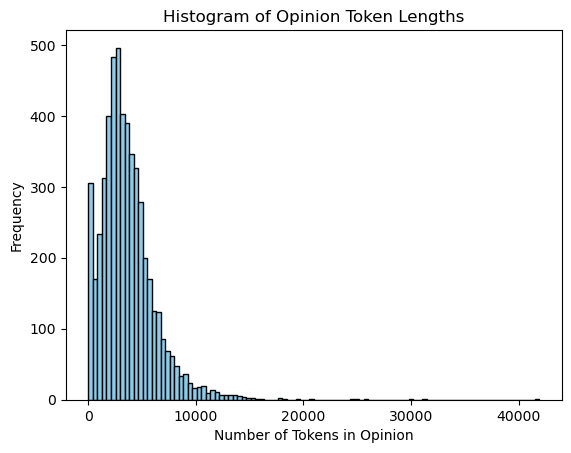

In [16]:


def plot_opinion_length_histogram(df):
    # Extract the text from the 'opinionOfTheCourt' column and calculate their token lengths
    token_lengths = df['opinionOfTheCourt'].apply(lambda x: len(x.split()))
    
    # Create a histogram
    plt.hist(token_lengths, bins=100, color='skyblue', edgecolor='black')
    
    # Set labels and title
    plt.xlabel('Number of Tokens in Opinion')
    plt.ylabel('Frequency')
    plt.title('Histogram of Opinion Token Lengths')
    
    # Show the plot
    plt.show()

# cases = FilterCases(cases_with_phrases_FAST_1)
# df = convert_cases_to_dataframe(cases)
plot_opinion_length_histogram(df)

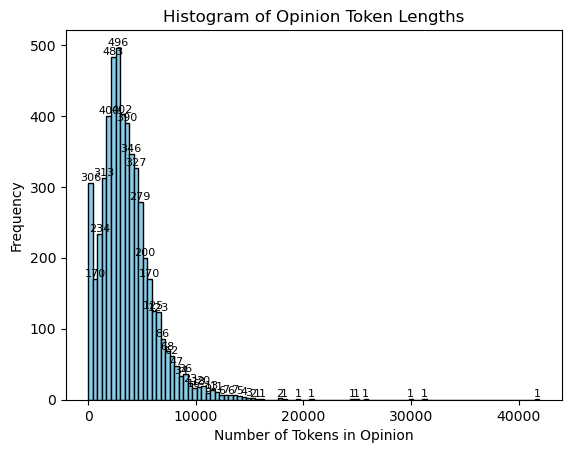

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_opinion_length_histogram(df):
    """
    Plots a histogram showing the distribution of token lengths of the 'opinionOfTheCourt' field in the given DataFrame,
    with annotations for the frequency of each bin.
    
    Parameters:
    - df: pandas DataFrame containing the dataset.
    """
    # Extract the text from the 'opinionOfTheCourt' column and calculate their token lengths
    token_lengths = df['opinionOfTheCourt'].apply(lambda x: len(x.split()))
    
    # Create a histogram
    counts, bins, patches = plt.hist(token_lengths, bins=100, color='skyblue', edgecolor='black')
    
    # Annotate each bar with the frequency
    for count, bin, patch in zip(counts, bins, patches):
        height = patch.get_height()
        if height > 0:  # Only annotate bars with a height greater than 0
            plt.text(patch.get_x() + patch.get_width() / 2, height, int(height), 
                     ha='center', va='bottom', fontsize=8)
    
    # Set labels and title
    plt.xlabel('Number of Tokens in Opinion')
    plt.ylabel('Frequency')
    plt.title('Histogram of Opinion Token Lengths')
    
    # Show the plot
    plt.show()

# Example usage
cases = FilterCases(cases_with_phrases_FAST_1)
df = convert_cases_to_dataframe(cases)
plot_opinion_length_histogram(df)


In [ ]:
def FindCaseByUrl(data, target_url):
    # Iterate through each item in the data
    for item in data:
        # Check if the 'url' key exists and matches the target URL
        if 'url' in item and item['url'] == target_url:
            # Return the matching case
            return item

    # Return None if no matching case is found
    return None

# Example usage:
target_url = "https://www.oyez.org/cases/1994/92-2038"
found_case = FindCaseByUrl(cases_without_phrases, target_url)
print(f"Syllabus: { found_case['justia_sections']['Syllabus']}")
print(f"Case: { found_case['justia_sections']['Case']}")
print(f"opinionOfTheCourt: { found_case['opinionOfTheCourt']}")

cases_with_phrases_one, cases_without_phrases, cases_with_per_curiam, cases_without_phrases_end = FindCasesWithPhrase([found_case], subkey, phrases_end)

print(cases_with_phrases_one[0]['opinionOfTheCourt'])

In [ ]:
print(cases_with_phrases_FAST_3[0]['opinionOfTheCourt'])
print(f"Case: { cases_with_phrases_FAST_3[0]['justia_sections']['Case']}")

In [31]:
print(type(dataset2))
print(dataset2.keys())
print(dataset2['train'][0])


<class 'datasets.dataset_dict.DatasetDict'>
dict_keys(['train'])
{'id': '1955_71', 'year': 1955, 'url': 'https://www.oyez.org/cases/1955/71', 'opinionOfTheCourt': 'MR. JUSTICE REED delivered the opinion of the Court. Affronti was tried in the United States District Court for the Western District of Missouri on a ten-count indictment charging him with illegal sales of narcotics. A jury found him guilty on counts two through ten, and a five-year sentence was imposed on each count, to be served consecutively. At the time of sentencing, execution of the sentences on counts six through ten was suspended and probation granted, the probation to commence at the Page 350 U. S. 80 expiration of the sentences on counts two through five. While serving his sentence on count two, petitioner filed a motion in the District Court seeking suspension of sentence and probation on counts three, four and five. The motion was denied upon the controlling authority of Phillips v. United States, 212 F.2d 327 (1

In [32]:
def convert_dataset_to_dataframe(dataset):
    data_opinion = []
    for item in dataset['train']:
        data_opinion.append({
            'id': item['id'],
            'year': item['year'],
            'url': item['url'],
            'opinionOfTheCourt': item['opinionOfTheCourt'],
            'syllabus': item['syllabus'],
            'issueArea': item['issueArea'],
            'decisionDirection': item['decisionDirection']
        })
    
    df = pd.DataFrame(data_opinion)
    return df

In [33]:
from sklearn.model_selection import StratifiedShuffleSplit
from datasets import Dataset
from transformers import LEDTokenizer, LEDForConditionalGeneration, Seq2SeqTrainingArguments, Trainer

df = convert_dataset_to_dataframe(dataset2)


# Create a combined stratification column
df['stratify_col'] = df['issueArea'].astype(str) + '_' + df['decisionDirection'].astype(str)

# Filter out classes with fewer than 2 samples
class_counts = df['stratify_col'].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df = df[df['stratify_col'].isin(valid_classes)]

# Initialize StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=42)
for train_index, temp_index in split.split(df, df['stratify_col']):
    train_df = df.iloc[train_index]
    temp_df = df.iloc[temp_index]

# Filter out classes with fewer than 2 samples in the temporary dataset
temp_class_counts = temp_df['stratify_col'].value_counts()
valid_temp_classes = temp_class_counts[temp_class_counts >= 2].index
temp_df = temp_df[temp_df['stratify_col'].isin(valid_temp_classes)]

# Further split the temp_df into validation and test sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.6, random_state=42)
for val_index, test_index in split.split(temp_df, temp_df['stratify_col']):
    val_df = temp_df.iloc[val_index]
    test_df = temp_df.iloc[test_index]

# Drop the stratification column
train_df = train_df.drop(columns=['stratify_col'])
val_df = val_df.drop(columns=['stratify_col'])
test_df = test_df.drop(columns=['stratify_col'])

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)

# Print the distribution to verify
print("Training set distribution:")
print(train_df['issueArea'].value_counts(normalize=True))
print(train_df['decisionDirection'].value_counts(normalize=True))

print("\nValidation set distribution:")
print(val_df['issueArea'].value_counts(normalize=True))
print(val_df['decisionDirection'].value_counts(normalize=True))

print("\nTest set distribution:")
print(test_df['issueArea'].value_counts(normalize=True))
print(test_df['decisionDirection'].value_counts(normalize=True))


Training set distribution:
issueArea
1.0     0.218613
8.0     0.202374
2.0     0.172392
9.0     0.105559
3.0     0.093691
7.0     0.056527
4.0     0.043410
12.0    0.042161
10.0    0.040912
6.0     0.012180
5.0     0.012180
Name: proportion, dtype: float64
decisionDirection
2.0    0.533729
1.0    0.466271
Name: proportion, dtype: float64

Validation set distribution:
issueArea
1.0     0.217799
8.0     0.201405
2.0     0.170960
9.0     0.105386
3.0     0.093677
7.0     0.056206
4.0     0.044496
10.0    0.042155
12.0    0.042155
5.0     0.014052
6.0     0.011710
Name: proportion, dtype: float64
decisionDirection
2.0    0.533958
1.0    0.466042
Name: proportion, dtype: float64

Test set distribution:
issueArea
1.0     0.219969
8.0     0.202808
2.0     0.173167
9.0     0.106084
3.0     0.092044
7.0     0.057722
12.0    0.042122
4.0     0.042122
10.0    0.040562
6.0     0.012480
5.0     0.010920
Name: proportion, dtype: float64
decisionDirection
2.0    0.536661
1.0    0.463339
Name: proport

In [36]:
# Load the tokenizer
tokenizer = LEDTokenizer.from_pretrained('allenai/led-base-16384')
i=0
def preprocess_function(examples):
    print(len(examples))
    inputs = examples['opinionOfTheCourt']
    targets = examples['syllabus']
    model_inputs = tokenizer(inputs, max_length=16000, truncation=True, padding='max_length')
    labels = tokenizer(targets, max_length=1000, truncation=True, padding='max_length')

    print(i+1)

    model_inputs['labels'] = labels['input_ids']

    batch = {}
    batch["input_ids"] = model_inputs.input_ids
    batch["attention_mask"] = model_inputs.attention_mask

    # create 0 global_attention_mask lists
    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [0 for _ in range(len(batch["input_ids"][0]))]
    ]

    # since above lists are references, the following line changes the 0 index for all samples
    batch["global_attention_mask"][0][0] = 1
    batch["labels"] = labels.input_ids

    # We have to make sure that the PAD token is ignored
    # -100 for loss
    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]

    return batch

# Apply the preprocessing function to the datasets
tokenized_train_dataset = train_dataset.map(preprocess_function, batched=True, remove_columns=train_dataset.column_names)
tokenized_val_dataset = val_dataset.map(preprocess_function, batched=True, remove_columns=val_dataset.column_names)
tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True, remove_columns=test_dataset.column_names)

Map:   0%|          | 0/3202 [00:00<?, ? examples/s]

8
1


Map:  31%|███       | 1000/3202 [00:18<00:41, 53.10 examples/s]

8
1


Map:  62%|██████▏   | 2000/3202 [00:36<00:21, 54.84 examples/s]

8


Map:  62%|██████▏   | 2000/3202 [00:48<00:21, 54.84 examples/s]

1


Map:  94%|█████████▎| 3000/3202 [00:55<00:03, 54.34 examples/s]

8
1


Map:   0%|          | 0/427 [00:00<?, ? examples/s]

8
1


Map:   0%|          | 0/641 [00:00<?, ? examples/s]

8
1


Map: 100%|██████████| 641/641 [00:11<00:00, 55.61 examples/s]


In [2]:
import torch

# Set the device to GPU 2
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda:2


In [37]:
# Load the model
model = LEDForConditionalGeneration.from_pretrained('allenai/led-base-16384')

# Set generate hyperparameters
model.config.num_beams = 2
model.config.max_length = 16000
model.config.min_length = 1000
model.config.length_penalty = 2.0
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2,
    predict_with_generate=True,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print("Evaluation results:", results)

# Generate summaries
def generate_summary(opinion):
    inputs = tokenizer(opinion, return_tensors='pt', max_length=16383, truncation=True, padding='max_length')
    summary_ids = model.generate(inputs['input_ids'].to("cuda"), max_length=1000, num_beams=4, early_stopping=True)
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# Test the model on a sample opinion
sample_opinion = df['opinionOfTheCourt'].iloc[0]
print("Opinion:", sample_opinion)
print("Generated Summary:", generate_summary(sample_opinion))

/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Input ids are automatically padded from 16000 to 16384 to be a multiple of `config.attention_window`: 1024
Input ids are automatically padded from 16000 to 16384 to be a multiple of `config.attention_window`: 1024


OutOfMemoryError: Caught OutOfMemoryError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/parallel/parallel_apply.py", line 83, in _worker
    output = module(*input, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/transformers/models/led/modeling_led.py", line 2398, in forward
    outputs = self.led(
              ^^^^^^^^^
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/transformers/models/led/modeling_led.py", line 2248, in forward
    encoder_outputs = self.encoder(
                      ^^^^^^^^^^^^^
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/transformers/models/led/modeling_led.py", line 1866, in forward
    layer_outputs = encoder_layer(
                    ^^^^^^^^^^^^^^
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/transformers/models/led/modeling_led.py", line 952, in forward
    attn_outputs = self.self_attn(
                   ^^^^^^^^^^^^^^^
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/transformers/models/led/modeling_led.py", line 761, in forward
    self_outputs = self.longformer_self_attn(
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1532, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/module.py", line 1541, in _call_impl
    return forward_call(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/transformers/models/led/modeling_led.py", line 248, in forward
    attn_probs = torch.masked_fill(attn_probs, is_index_masked[:, :, None, None], 0.0)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 1.50 GiB. GPU 


: 

In [ ]:
df['generated_summary'] = df['opinionOfTheCourt'].apply(generate_summary)

# Prepare data for BERT
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess_bert_function(examples):
    return bert_tokenizer(examples['generated_summary'], padding='max_length', truncation=True, max_length=512)

# Convert the DataFrame to a Dataset
bert_dataset = Dataset.from_pandas(df)

# Apply the preprocessing function to the dataset
tokenized_bert_dataset = bert_dataset.map(preprocess_bert_function, batched=True)

# Split the dataset into train, validation, and test sets
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, temp_index in split.split(df, df['stratify_col']):
    train_df = df.iloc[train_index]
    temp_df = df.iloc[temp_index]

split = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_index, test_index in split.split(temp_df, temp_df['stratify_col']):
    val_df = temp_df.iloc[val_index]
    test_df = temp_df.iloc[test_index]

# Convert to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
val_dataset = Dataset.from_pandas(val_df)
test_dataset = Dataset.from_pandas(test_df)


In [ ]:

# Load the BERT model
bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Define training arguments for BERT
bert_training_args = TrainingArguments(
    output_dir='./bert_results',
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
)

# Initialize the Trainer for BERT
bert_trainer = Trainer(
    model=bert_model,
    args=bert_training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Train the BERT model
bert_trainer.train()

# Evaluate the BERT model
bert_results = bert_trainer.evaluate()
print("BERT Evaluation results:", bert_results)


In [ ]:
# Predict decisionDirection using BERT
predictions = bert_trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Calculate the decision direction flip rate
original_labels = test_df['decisionDirection'].values
flip_rate = np.mean(predicted_labels != original_labels)
print("Decision Direction Flip Rate:", flip_rate)

# Calculate the distance-based metric
probabilities = torch.nn.functional.softmax(torch.tensor(predictions.predictions), dim=-1).numpy()
original_probabilities = np.zeros_like(probabilities)
for i, label in enumerate(original_labels):
    original_probabilities[i, label] = 1

absolute_differences = np.abs(probabilities - original_probabilities)
distance_metric = np.mean(np.sum(absolute_differences, axis=1))
print("Distance-based Metric:", distance_metric)

In [ ]:


# Assuming you have already trained the BERT model and have the test dataset

# Predict decisionDirection using BERT
predictions = bert_trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions.predictions, axis=1)

# Extract original labels and group information
original_labels = test_df['decisionDirection'].values
issue_areas = test_df['issueArea'].values

# Define groups based on issueArea
groups = np.unique(issue_areas)

# Initialize dictionaries to store metrics
accuracy = {}
precision = {}
recall = {}
f1 = {}

# Calculate metrics for each group
for group in groups:
    group_indices = np.where(issue_areas == group)[0]
    group_original_labels = original_labels[group_indices]
    group_predicted_labels = predicted_labels[group_indices]
    
    accuracy[group] = accuracy_score(group_original_labels, group_predicted_labels)
    precision[group] = precision_score(group_original_labels, group_predicted_labels, average='macro')
    recall[group] = recall_score(group_original_labels, group_predicted_labels, average='macro')
    f1[group] = f1_score(group_original_labels, group_predicted_labels, average='macro')

# Print metrics for each group
for group in groups:
    print(f"Issue Area {group}:")
    print(f"  Accuracy: {accuracy[group]:.4f}")
    print(f"  Precision: {precision[group]:.4f}")
    print(f"  Recall: {recall[group]:.4f}")
    print(f"  F1 Score: {f1[group]:.4f}")

# Apply the 80% Rule
selection_rates = {group: np.mean(predicted_labels[issue_areas == group] == 1) for group in groups}
max_selection_rate = max(selection_rates.values())
for group, rate in selection_rates.items():
    if rate < 0.8 * max_selection_rate:
        print(f"Group {group} violates the 80% rule with a selection rate of {rate:.4f}")

# Calculate Statistical Parity
positive_rates = {group: np.mean(predicted_labels[issue_areas == group] == 1) for group in groups}
for group, rate in positive_rates.items():
    print(f"Group {group} positive prediction rate: {rate:.4f}")

# Calculate Equalized Odds
true_positive_rates = {group: np.mean((predicted_labels[issue_areas == group] == 1) & (original_labels[issue_areas == group] == 1)) for group in groups}
false_positive_rates = {group: np.mean((predicted_labels[issue_areas == group] == 1) & (original_labels[issue_areas == group] == 0)) for group in groups}
for group in groups:
    print(f"Group {group} true positive rate: {true_positive_rates[group]:.4f}")
    print(f"Group {group} false positive rate: {false_positive_rates[group]:.4f}")

# Visualize Disparities
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].bar(groups, [accuracy[group] for group in groups])
ax[0].set_title('Accuracy by Issue Area')
ax[0].set_xlabel('Issue Area')
ax[0].set_ylabel('Accuracy')

ax[1].bar(groups, [precision[group] for group in groups])
ax[1].set_title('Precision by Issue Area')
ax[1].set_xlabel('Issue Area')
ax[1].set_ylabel('Precision')

ax[2].bar(groups, [recall[group] for group in groups])
ax[2].set_title('Recall by Issue Area')
ax[2].set_xlabel('Issue Area')
ax[2].set_ylabel('Recall')

plt.show()


In [1]:
import re
import pandas as pd
import logging
from datasets import load_dataset, Dataset

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Load the dataset
logging.info("Loading dataset from Hugging Face Hub.")
dataset = load_dataset("ahmed275/FILTERED_SLOW")

# Define the regex patterns
pattern_page = r'\((Page|Pp\.) \d+ U\. S\. \d+(-\d+)?\)'
pattern_syllabus = r'.*?Syllabus\s*'

# Function to clean the opinionOfTheCourt field
def clean_opinion(text):
    return re.sub(pattern_page, '', text)

# Function to clean the syllabus field
def clean_syllabus(text):
    # Remove everything before and including "Syllabus"
    text = re.sub(pattern_syllabus, '', text, flags=re.IGNORECASE)
    # Remove specific patterns
    return re.sub(pattern_page, '', text)

# Clean the dataset
logging.info("Cleaning the dataset.")
cleaned_data = []
for item in dataset['train']:
    try:
        cleaned_item = {
            'id': item['id'],
            'year': item['year'],
            'url': item['url'],
            'opinionOfTheCourt': clean_opinion(item['opinionOfTheCourt']),
            'syllabus': clean_syllabus(item['syllabus']),
            'issueArea': item['issueArea'],
            'decisionDirection': item['decisionDirection']
        }
        cleaned_data.append(cleaned_item)
    except Exception as e:
        logging.error(f"Error cleaning item with id {item['id']}: {e}")

# Convert cleaned data to a Pandas DataFrame
logging.info("Converting cleaned data to Pandas DataFrame.")
df = pd.DataFrame(cleaned_data)

# Convert DataFrame to a Dataset object
logging.info("Converting DataFrame to Dataset object.")
cleaned_dataset = Dataset.from_pandas(df)

# Push the dataset to the Hugging Face Hub
name = "OpinionOfTheCourt_dataset"  # Replace with your desired dataset name
logging.info(f"Pushing dataset to Hugging Face Hub with name: {name}.")
try:
    cleaned_dataset.push_to_hub(f"ahmed275/{name}", private=False)
    logging.info("Dataset successfully pushed to Hugging Face Hub.")
except Exception as e:
    logging.error(f"Failed to push dataset to Hugging Face Hub: {e}")


/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-15 13:13:14,305 - INFO - Loading dataset from Hugging Face Hub.
2024-10-15 13:13:16,790 - INFO - Cleaning the dataset.


KeyboardInterrupt: 

In [ ]:
from datasets import load_dataset, concatenate_datasets, DatasetDict

# Load the datasets
dataset1 = load_dataset("ahmed275/OpinionOfTheCourt_dataset")
dataset2 = load_dataset("ahmed275/cases_with_opinion")

# Concatenate the datasets
# Assuming both datasets have the same structure and are in the 'train' split
combined_dataset = concatenate_datasets([dataset1['train'], dataset2['train']])

# Create a DatasetDict if you want to maintain the 'train' split
combined_dataset_dict = DatasetDict({'train': combined_dataset})

# Save the combined dataset to a new dataset repository
# Replace 'your-username/new-dataset-name' with your Hugging Face username and desired dataset name
combined_dataset_dict.push_to_hub("yahmed275/OpinionOfTheCourt_dataset_new")


In [14]:
for item in data:
    if 'scdb_elements' in item and 'partyWinning' in item['scdb_elements']:
        print(item['scdb_elements'])
    break
    

{'caseId': '1955-009', 'docketId': '1955-009-01', 'caseIssuesId': '1955-009-01-01', 'voteId': '1955-009-01-01-01', 'dateDecision': '12/5/1955', 'decisionType': 1, 'usCite': '350 U.S. 79', 'sctCite': '76 S. Ct. 171', 'ledCite': '100 L. Ed. 2d 62', 'lexisCite': '1955 U.S. LEXIS 35', 'term': 1955, 'naturalCourt': 1403, 'chief': 'Warren', 'docket': '71', 'caseName': 'AFFRONTI v. UNITED STATES', 'dateArgument': '11/15/1955', 'dateRearg': nan, 'petitioner': 126.0, 'petitionerState': nan, 'respondent': 27.0, 'respondentState': nan, 'jurisdiction': 1.0, 'adminAction': nan, 'adminActionState': nan, 'threeJudgeFdc': 0.0, 'caseOrigin': 87.0, 'caseOriginState': nan, 'caseSource': 28.0, 'caseSourceState': nan, 'lcDisagreement': 0.0, 'certReason': 2.0, 'lcDisposition': 2.0, 'lcDispositionDirection': 1.0, 'declarationUncon': 1.0, 'caseDisposition': 2.0, 'caseDispositionUnusual': 0.0, 'partyWinning': 0.0, 'precedentAlteration': 0.0, 'voteUnclear': 0.0, 'issue': 90320.0, 'issueArea': 9.0, 'decisionDire

In [19]:
party_winning_data = {}
for item in data:
    if 'scdb_elements' in item and 'partyWinning' in item['scdb_elements']:
        case_id = item.get('id')  # Assuming 'id' is the common identifier
        party_winning_data[case_id] = item['scdb_elements']['partyWinning']

# Load the existing dataset
existing_dataset = load_dataset("ahmed275/OpinionOfTheCourt_dataset_new")

# Update the existing dataset with partyWinning information
def update_entry(entry):
    case_id = entry.get('id')
    if case_id in party_winning_data:
        entry['partyWinning'] = party_winning_data[case_id]
    return entry

# Use map to update the dataset
updated_dataset = existing_dataset.map(update_entry)

# Verify the first entry
print("First entry after update:", updated_dataset['train'][0])
#existing_dataset.push_to_hub("ahmed275/OpinionOfTheCourt_dataset_new_updated")

Map: 100%|██████████| 5358/5358 [00:00<00:00, 8070.55 examples/s]

First entry after update: {'id': '1955_71', 'year': 1955, 'url': 'https://www.oyez.org/cases/1955/71', 'opinionOfTheCourt': 'MR. JUSTICE REED delivered the opinion of the Court. Affronti was tried in the United States District Court for the Western District of Missouri on a ten-count indictment charging him with illegal sales of narcotics. A jury found him guilty on counts two through ten, and a five-year sentence was imposed on each count, to be served consecutively. At the time of sentencing, execution of the sentences on counts six through ten was suspended and probation granted, the probation to commence at the  expiration of the sentences on counts two through five. While serving his sentence on count two, petitioner filed a motion in the District Court seeking suspension of sentence and probation on counts three, four and five. The motion was denied upon the controlling authority of Phillips v. United States, 212 F.2d 327 (1954), which held that the district courts have no power 

In [21]:
updated_dataset.push_to_hub("ahmed275/OpinionOfTheCourt_dataset_new_updated")

Uploading the dataset shards: 100%|██████████| 1/1 [00:05<00:00,  5.25s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/ahmed275/OpinionOfTheCourt_dataset_new_updated/commit/3c778145c56fb37d640b22204d49edb5d6861877', commit_message='Upload dataset', commit_description='', oid='3c778145c56fb37d640b22204d49edb5d6861877', pr_url=None, pr_revision=None, pr_num=None)

In [5]:
# Dictionary to store vote distribution data
vote_distribution_data = {}

# Iterate over each item in the data
for item in data:
    if 'scdb_elements' in item:
        scdb_elements = item['scdb_elements']
        if 'majVotes' in scdb_elements and 'minVotes' in scdb_elements:
            majVotes = scdb_elements['majVotes']
            minVotes = scdb_elements['minVotes']
            # Calculate voteDistribution safely
            if (majVotes + minVotes) != 0:
                voteDistribution = majVotes / (majVotes + minVotes)
                case_id = item.get('id')  # Assuming 'id' is the common identifier
                vote_distribution_data[case_id] = voteDistribution

# Load the existing dataset
existing_dataset = load_dataset("ahmed275/OpinionOfTheCourt_dataset_new_updated")

# Update the existing dataset with voteDistribution information
def update_entry(entry):
    case_id = entry.get('id')
    if case_id in vote_distribution_data:
        entry['voteDistribution'] = vote_distribution_data[case_id]
    return entry

# Use map to update the dataset
updated_dataset = existing_dataset.map(update_entry)

# Push the updated dataset to the hub
updated_dataset.push_to_hub("ahmed275/OpinionOfTheCourt_dataset_new_updated")


Uploading the dataset shards: 100%|██████████| 1/1 [00:05<00:00,  5.53s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/ahmed275/OpinionOfTheCourt_dataset_new_updated/commit/5ea22039d745c4b619eb97a5ab48228eca068fac', commit_message='Upload dataset', commit_description='', oid='5ea22039d745c4b619eb97a5ab48228eca068fac', pr_url=None, pr_revision=None, pr_num=None)

In [3]:
from datasets import load_dataset

dataset = load_dataset("coastalcph/fairlex", "scotus")


/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/datasets/load.py:1486: FutureWarning: The repository for coastalcph/fairlex contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/coastalcph/fairlex
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [10]:
dataset['train'][69]

{'text': 'United States Supreme Court U.S. v. WIESENFELD WAREHOUSE CO.(1964) No. 92 Argued: January 16, 1964Decided: February 17, 1964 </s>  Appellee, a public storage warehouseman, was charged by criminal information with violations of 301 (k) of the Federal Food, Drug, and Cosmetic Act, which prohibits acts involving defacement of labels of food and other specified articles held for sale after interstate shipment and the "doing of any other act" with respect to such articles which results in their being adulterated or misbranded. Under 402 (a) (4) adulteration is defined to include holding food under insanitary conditions whereby it may have been contaminated with filth. The District Court, construing the statute under the rule of ejusdem generis as applying only to acts of the same general nature as those specifically enumerated with respect to label-defacing and as being too vague to include the mere "holding" of articles, dismissed the information for failure to state an offense. 

In [7]:
# Define categorization for respondent types using numeric values
public_entities = set([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 301, 302, 303, 304, 305, 306, 307, 308, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 501, 600])

persons = set([100, 102, 106, 110, 111, 112, 126, 129, 134, 135, 136, 137, 138, 140, 142, 145, 153, 154, 155, 162, 163, 164, 165, 166, 168, 169, 172, 173, 174, 175, 177, 179, 180, 182, 183, 186, 188, 193, 195, 199, 200, 202, 204, 206, 208, 211, 212, 213, 214, 215, 217, 218, 222, 223, 224, 226, 227, 229, 230, 236, 237, 239, 240, 241, 244, 247, 248, 250, 251, 253, 254, 256, 257, 260])

organizations = set([107, 108, 114, 119, 122, 130, 131, 133, 139, 141, 143, 144, 146, 147, 148, 149, 150, 151, 152, 157, 158, 159, 160, 161, 170, 171, 176, 178, 181, 184, 185, 187, 189, 190, 191, 192, 194, 196, 197, 198, 201, 205, 207, 209, 216, 219, 220, 221, 225, 228, 231, 232, 233, 234, 235, 238, 242, 243, 245, 246, 249, 252, 255, 258, 259])

facilities = set([109, 115, 116, 117, 118, 120, 121, 123, 124, 125, 127, 128, 132, 156, 167, 203, 210, 255])

# Function to determine Respondent Type based on respondent id (numeric values)
def get_respondent_type(respondent_id):
    if respondent_id in public_entities:
        return 1  # Public Entity
    elif respondent_id in persons:
        return 2  # Person
    elif respondent_id in organizations:
        return 3  # Organization
    elif respondent_id in facilities:
        return 4  # Facility
    else:
        return 0  # Unknown or not categorized

# Extract respondent type from scdb_elements and update dataset
respondent_type_data = {}
for item in data:
    if 'scdb_elements' in item and 'respondent' in item['scdb_elements']:
        case_id = item.get('id')  # Assuming 'id' is the common identifier
        respondent_id = item['scdb_elements']['respondent']
        respondent_type = get_respondent_type(respondent_id)
        respondent_type_data[case_id] = respondent_type

# Load the existing dataset
existing_dataset = load_dataset("ahmed275/OpinionOfTheCourt_dataset_new_updated")

# Update the existing dataset with Respondent Type information
def update_entry(entry):
    case_id = entry.get('id')
    if case_id in respondent_type_data:
        entry['respondentType'] = respondent_type_data[case_id]
    return entry

# Use map to update the dataset
updated_dataset = existing_dataset.map(update_entry)

# Verify the first entry
print("First entry after update:", updated_dataset['train'][0])

# Push the updated dataset to the hub
updated_dataset.push_to_hub("ahmed275/OpinionOfTheCourt_dataset_new_updated")


Map: 100%|██████████| 5358/5358 [00:00<00:00, 7037.45 examples/s]


First entry after update: {'id': '1955_71', 'year': 1955, 'url': 'https://www.oyez.org/cases/1955/71', 'opinionOfTheCourt': 'MR. JUSTICE REED delivered the opinion of the Court. Affronti was tried in the United States District Court for the Western District of Missouri on a ten-count indictment charging him with illegal sales of narcotics. A jury found him guilty on counts two through ten, and a five-year sentence was imposed on each count, to be served consecutively. At the time of sentencing, execution of the sentences on counts six through ten was suspended and probation granted, the probation to commence at the  expiration of the sentences on counts two through five. While serving his sentence on count two, petitioner filed a motion in the District Court seeking suspension of sentence and probation on counts three, four and five. The motion was denied upon the controlling authority of Phillips v. United States, 212 F.2d 327 (1954), which held that the district courts have no power 

Uploading the dataset shards: 100%|██████████| 1/1 [00:04<00:00,  4.17s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/ahmed275/OpinionOfTheCourt_dataset_new_updated/commit/5317ad5e000e26cc4426624843e0108e6e382cdf', commit_message='Upload dataset', commit_description='', oid='5317ad5e000e26cc4426624843e0108e6e382cdf', pr_url=None, pr_revision=None, pr_num=None)

In [16]:
# ADD RESPONDENT TO DATASET
# Extract respondent type from scdb_elements and update dataset
respondent_type_data = {}
for item in data:
    if 'scdb_elements' in item and 'respondent' in item['scdb_elements']:
        case_id = item.get('id')  # Assuming 'id' is the common identifier
        respondent_id = item['scdb_elements']['respondent']
        respondent_type_data[case_id] = respondent_id

# Load the existing dataset
existing_dataset = load_dataset("ahmed275/OpinionOfTheCourt_dataset_new_updated")

# Update the existing dataset with Respondent Type information
def update_entry(entry):
    case_id = entry.get('id')
    if case_id in respondent_type_data:
        entry['respondent'] = respondent_type_data[case_id]
    return entry

# Use map to update the dataset
updated_dataset = existing_dataset.map(update_entry)

# Verify the first entry
print("First entry after update:", updated_dataset['train'][0])

# Push the updated dataset to the hub
updated_dataset.push_to_hub("ahmed275/OpinionOfTheCourt_dataset_new_updated")


Map: 100%|██████████| 5358/5358 [00:00<00:00, 5505.98 examples/s]


First entry after update: {'id': '1955_71', 'year': 1955, 'url': 'https://www.oyez.org/cases/1955/71', 'opinionOfTheCourt': 'MR. JUSTICE REED delivered the opinion of the Court. Affronti was tried in the United States District Court for the Western District of Missouri on a ten-count indictment charging him with illegal sales of narcotics. A jury found him guilty on counts two through ten, and a five-year sentence was imposed on each count, to be served consecutively. At the time of sentencing, execution of the sentences on counts six through ten was suspended and probation granted, the probation to commence at the  expiration of the sentences on counts two through five. While serving his sentence on count two, petitioner filed a motion in the District Court seeking suspension of sentence and probation on counts three, four and five. The motion was denied upon the controlling authority of Phillips v. United States, 212 F.2d 327 (1954), which held that the district courts have no power 

Uploading the dataset shards: 100%|██████████| 1/1 [00:04<00:00,  4.81s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/ahmed275/OpinionOfTheCourt_dataset_new_updated/commit/9831228994bc4f7f462f7800801e58a513bba1cc', commit_message='Upload dataset', commit_description='', oid='9831228994bc4f7f462f7800801e58a513bba1cc', pr_url=None, pr_revision=None, pr_num=None)

In [2]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset("ahmed275/opinions_dataset_temporal")

# # Specify the column you want to remove
# column_to_remove = 'Respondent Type'  # Ensure this matches the exact column name

# # Use the remove_columns method to remove the specified column from all splits
# updated_dataset = dataset.remove_columns(column_to_remove)

# Verify by checking the column names after removal
print("Columns after removal:", dataset['train'].column_names)

# # Push the updated dataset to the Hugging Face hub
# updated_dataset.push_to_hub("ahmed275/OpinionOfTheCourt_dataset_new_updated")


Columns after removal: ['id', 'year', 'url', 'opinionOfTheCourt', 'syllabus', 'issueArea', 'decisionDirection', 'partyWinning', 'voteDistribution', 'respondentType', 'respondent', '__index_level_0__']


In [3]:
from datasets import load_dataset

# Load an older version using the `revision` argument (commit hash or tag)
dataset = load_dataset("ahmed275/opinions_dataset_temporal", revision="5317ad5e000e26cc4426624843e0108e6e382cdf")

# Check the columns to verify it's the older version
print("Columns:", dataset['train'].column_names)

dataset.push_to_hub("ahmed275/OpinionOfTheCourt_dataset_new_updated")

Columns: ['id', 'year', 'url', 'opinionOfTheCourt', 'syllabus', 'issueArea', 'decisionDirection', 'partyWinning', 'voteDistribution', 'Respondent Type', 'respondentType']


Uploading the dataset shards: 100%|██████████| 1/1 [00:02<00:00,  2.57s/it]


CommitInfo(commit_url='https://huggingface.co/datasets/ahmed275/OpinionOfTheCourt_dataset_new_updated/commit/449a1d3cb9574edb173bd62e75961062e15cfca2', commit_message='Upload dataset', commit_description='', oid='449a1d3cb9574edb173bd62e75961062e15cfca2', pr_url=None, pr_revision=None, pr_num=None)

In [5]:
import torch
import os


os.environ.pop("CUDA_VISIBLE_DEVICES", None)
def set_gpu_device(gpu_number):
    device = "cpu"
    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        print("CUDA is available")
        print("Number of GPUs:", num_gpus)
        for i in range(num_gpus):
            print(f"Device {i}: {torch.cuda.get_device_name(i)}")     
        if 0 <= gpu_number < num_gpus:
            os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_number)
            device = torch.device(f"cuda:{gpu_number}")
            
            print(f"Using GPU {gpu_number}")
        else:
            print(f"Invalid GPU number: {gpu_number}. Please choose a number between 0 and {num_gpus - 1}.")
    else:
        print("CUDA is not available")   
    return device

device = set_gpu_device(1)
print(f"Selected device: {device}")

CUDA is available
Number of GPUs: 4
Device 0: NVIDIA A40
Device 1: NVIDIA A40
Device 2: NVIDIA A40
Device 3: NVIDIA A40
Using GPU 1
Selected device: cuda:1


In [6]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("launch/POLITICS")

# Load the model
model = AutoModelForMaskedLM.from_pretrained("launch/POLITICS")

# Verify the tokenizer and model
print("Tokenizer and model loaded successfully.")
print(f"Tokenizer vocab size: {tokenizer.vocab_size}")
print(f"Model config: {model.config}")


Tokenizer and model loaded successfully.
Tokenizer vocab size: 50265
Model config: RobertaConfig {
  "_name_or_path": "launch/POLITICS",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "transformers_version": "4.41.2",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}



In [11]:
print("Max length:", tokenizer.model_max_length)
print("Current max position embeddings:", model.config.max_position_embeddings)


Max length: 512
Current max position embeddings: 1024


In [10]:
print("Current max position embeddings:", model.config.max_position_embeddings)

# New desired max length
new_max_length = 1024

# Access the positional embeddings
old_embeddings = model.roberta.embeddings.position_embeddings

# Create a new embeddings layer
new_embeddings = torch.nn.Embedding(new_max_length, old_embeddings.embedding_dim)

# Copy weights from the old embeddings to the new embeddings
num_tokens_to_copy = min(old_embeddings.num_embeddings, new_max_length)
new_embeddings.weight.data[:num_tokens_to_copy] = old_embeddings.weight.data[:num_tokens_to_copy]

# Replace the old embeddings with the new embeddings
model.roberta.embeddings.position_embeddings = new_embeddings

# Update the model configuration
model.config.max_position_embeddings = new_max_length

# Verify the change
print("New max position embeddings:", model.config.max_position_embeddings)


Current max position embeddings: 1024
New max position embeddings: 1024


In [4]:
!pip3 install --upgrade transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 62.5 MB/s eta 0:00:0000:010:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.0
    Uninstalling transformers-4.46.0:
      Successfully uninstalled transformers-4.46.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
alignscore 0.1.3 requires torch<2,>=1.12.1, but you have torch 2.5.1 which is incompatible.


In [1]:
import sled  # ** required so SLED would be properly registered by the AutoClasses **


In [4]:
import sled  # ** required so SLED would be properly registered by the AutoClasses **
from transformers import AutoTokenizer, AutoModel
tokenizer = AutoTokenizer.from_pretrained('tau/bart-base-sled')
model = AutoModel.from_pretrained('tau/bart-base-sled')
inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state



/home/mostah/anaconda3/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ValueError: Tokenizer class SledTokenizer does not exist or is not currently imported.